# Большая домашка 1: классификация отзывов

## Данные

Скачиваются по [ссылке](https://drive.google.com/open?id=1gJEpwM3zdV5xe9nRU0VwQmGTiOTQdp10). Это отзывы пользователей на фильмы с КиноПоиска.

In [11]:
import pandas as pd
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df = pd.read_csv('reviews.csv')

In [13]:
df.head()

,label,text
0,1,Эпиграф Добро которое ты делаешь от сердца ты ...
1,1,Теперь это один из моих любимых фильмов в жанр...
2,1,Что скрыто в фильме Лучше не бывает Одна шикар...
3,1,Перед нами очень милое и доброе кино которое л...
4,1,Завязка Мелвин Удал популярный писатель Нет не...


In [0]:
set(df.label)

{-1, 0, 1}

В колонке `label` три класса: положительный (1), нейтральный (0) и отрицательный (-1).

## Задание

Побейте baseline выше как минимум тремя способами.


**Обязательно**:
* попробовать разный препроцессинг (2 балла)
* попробовать разные классификаторы (2 балла)
* поподбирать гиперпараметры классификаторов, можно с использованием GreedSearch (2 балла)
* попробуйте объяснить полученные результаты (2 балла)
* визуализируйте веса признаков для лучшей модели (если лучшая модель не выдаёт коэффициенты признаков, возьмите логистическую регрессию); какие признаки оказались самыми значимыми? (2 балла)

Если вы перебрали уже много разных способов и выполнили все обязательные критерии, но побить baseline тремя способами так и не получилось, не беспокойтесь. Главное -- полнота попыток :)

Good luck and have fun! ;)

1. Посмотрим на данные: сколько элементов к какому классу относятся


In [4]:
for el in set(df.label):
    print(el, len(df.label.loc[df.label == el]))

0 5645
1 36480
-1 4376


2. Сделаем импорт всего, что нам понадобится


In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')


In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



%matplotlib inline

Начнем с установки Baseline c помощью наивного Байеса и CountVectorizer

## Baseline


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label)
# делим данные на кусочки для обучения и тестирования


In [11]:
vec = CountVectorizer() #берем векторайзер
bow = vec.fit_transform(X_train) #делаем матрицу из признаков на обучающем куске
nb = MultinomialNB() #берем модель с наивным байесом
nb.fit(bow, y_train) #тренируем модель на матрице из обучающего куска
test_bow = vec.transform(X_test) # сделали матрицу для тестового куска
print(classification_report(y_test, nb.predict(test_bow)))



              precision    recall  f1-score   support

          -1       0.78      0.21      0.33      1109
           0       0.42      0.06      0.10      1408
           1       0.81      0.99      0.89      9109

   micro avg       0.81      0.81      0.81     11626
   macro avg       0.67      0.42      0.44     11626
weighted avg       0.76      0.81      0.74     11626



Вот этот результат нужно побить тремя способами. 

Из любопытства посмотрим на векторайзер:

In [28]:
# все токены, которые векторайзер рассматривал
vec.get_feature_names()[:10]

['аа',
 'ааа',
 'аааа',
 'аааай',
 'аааарон',
 'аааж',
 'аак',
 'аалана',
 'аамир',
 'аамира']

In [27]:
# я так понимаю, это токен и его индекс
list(vec.vocabulary_.items())[:10]

[('фильм', 304992),
 ('взвод', 27653),
 ('не', 144173),
 ('является', 326161),
 ('ни', 156275),
 ('обвинением', 159319),
 ('исповедью', 93511),
 ('стремление', 276805),
 ('выяснить', 45001),
 ('кто', 112892)]

и сделаем матрицу для наглядности:

In [31]:
confusion_matrix(y_test, nb.predict(test_bow))

array([[ 233,   73,  803],
       [  46,   79, 1283],
       [  18,   36, 9055]])

In [34]:
nb.classes_

array([-1,  0,  1])

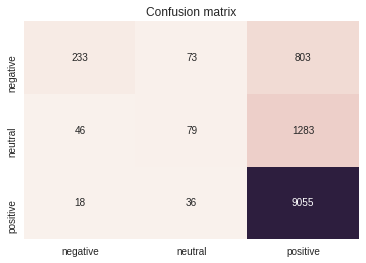

In [35]:
categories = ['negative', 'neutral', 'positive']
sns.heatmap(data=confusion_matrix(y_test, nb.predict(test_bow)),
            annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

По горизонтали - как на самом деле, по вертикали - предсказанные. То есть нейтральные отзывы наш классификатор предсказывает очень плохо. Всего нейтральных отзывов 46+79+1283 в тестовой выборке, и правильно предсказанных нейтральных всего 79, большая часть неверно угадана как положительные отзывы. Положительные отзывы угаданы лучше всего, просто потому, что их больше. 

Попробуем побить бейзлайн, начнем с tf-idf Vectorizer
## Tf-idf Vectorizer

In [15]:
vec_Tf = TfidfVectorizer()
bow_Tf = vec_Tf.fit_transform(X_train) 
clf_Tf = MultinomialNB()
clf_Tf.fit(bow_Tf, y_train)
test_bow_Tf = vec_Tf.transform(X_test)
pred_Tf = clf_Tf.predict(test_bow_Tf)
print(classification_report(y_test, pred_Tf))




              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1109
           0       0.00      0.00      0.00      1408
           1       0.78      1.00      0.88      9109

   micro avg       0.78      0.78      0.78     11626
   macro avg       0.26      0.33      0.29     11626
weighted avg       0.61      0.78      0.69     11626



Результаты нулевые, где классы "0" и "-1". Возможно, значимые слова из обучающей выборки не встретились в тестовой выборке, и класс "1" был проставлен как самый часто встречающийся. Теперь займемся препроцессингом.

## Препроцессинг: word_tokenize и PyMorphy:

Попробуем использовать наивный байес с собственным токенизатором

In [22]:
!pip install pymorphy2
# pip install pymorphy2-dicts
# pip install DAWG-Python

    100% |████████████████████████████████| 51kB 2.0MB/s 
    100% |████████████████████████████████| 7.1MB 2.9MB/s 


In [24]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
from pymorphy2 import MorphAnalyzer
morphy2 = MorphAnalyzer()
def my_preproc_morphy2(text):
    text = word_tokenize(text)
    return [morphy2.parse(word)[0].normal_form for word in text]
vec_M = CountVectorizer(tokenizer=my_preproc_morphy2)
bow_M = vec_M.fit_transform(X_train)
nb_M = MultinomialNB()
nb_M.fit(bow_M, y_train)
test_bow_M = vec_M.transform(X_test) 
print(classification_report(y_test, nb_M.predict(test_bow_M)))

              precision    recall  f1-score   support

          -1       0.67      0.49      0.57      1109
           0       0.39      0.22      0.28      1408
           1       0.87      0.96      0.91      9109

   micro avg       0.82      0.82      0.82     11626
   macro avg       0.64      0.55      0.58     11626
weighted avg       0.79      0.82      0.80     11626



Токенизатор на основе пайМорфи работал почти час, но выдал хороший результат. Бейзлайн побит в первый раз! Посмотрим на confusion matrix

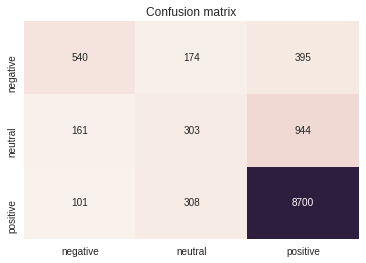

In [36]:
categories = ['negative', 'neutral', 'positive']
sns.heatmap(data=confusion_matrix(y_test, nb_M.predict(test_bow_M)),
            annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

достаточно ощутимо улучшились результаты для негативных и нейтральных отзывов, а для положительных немного ухудшились.

Попробуем сделать то же самое, но без пайморфи, а просто с токенайзером из нлтк:

In [26]:
vec_tok_nltk = CountVectorizer(tokenizer=word_tokenize)
bow_tok_nltk = vec_tok_nltk.fit_transform(X_train)
nb_tok_nltk = MultinomialNB()
nb_tok_nltk.fit(bow_tok_nltk, y_train)
test_bow_tok_nltk = vec_tok_nltk.transform(X_test) 
print(classification_report(y_test, nb_tok_nltk.predict(test_bow_tok_nltk)))


              precision    recall  f1-score   support

          -1       0.82      0.15      0.25      1109
           0       0.44      0.03      0.06      1408
           1       0.80      1.00      0.89      9109

   micro avg       0.80      0.80      0.80     11626
   macro avg       0.68      0.39      0.40     11626
weighted avg       0.76      0.80      0.73     11626



Результат чууууть ниже, чем бейзлайн. Интересно, почему)

Попробуем с биграммами:

In [37]:
vec_bi = CountVectorizer(ngram_range=(2, 2), tokenizer=word_tokenize)
bow_bi = vec_bi.fit_transform(X_train)
nb_bi = MultinomialNB()
nb_bi.fit(bow_bi, y_train)
test_bow_bi = vec_bi.transform(X_test) 
print(classification_report(y_test, nb_bi.predict(test_bow_bi)))


              precision    recall  f1-score   support

          -1       1.00      0.00      0.00      1109
           0       0.50      0.00      0.00      1408
           1       0.78      1.00      0.88      9109

   micro avg       0.78      0.78      0.78     11626
   macro avg       0.76      0.33      0.29     11626
weighted avg       0.77      0.78      0.69     11626



получилась какая-то фигня. воспроизведем её графически:

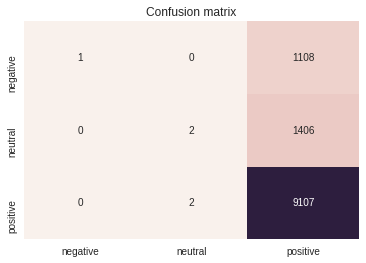

In [38]:
categories = ['negative', 'neutral', 'positive']
sns.heatmap(data=confusion_matrix(y_test, nb_bi.predict(test_bow_bi)),
            annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

то есть наша модель тупо записала все отзывы в положительные. Наверное, пора заканчивать с препроцессингом) Посмотрим еще повнимательнее на то, что у нас в текстах.

In [39]:
corpus = [token for post in df.text for token in word_tokenize(post)]
print(len(corpus))
freq_dict = Counter(corpus)
freq_dict.most_common(100)

16985398


[('и', 645077),
 ('в', 449243),
 ('не', 351648),
 ('что', 215199),
 ('на', 213878),
 ('с', 163190),
 ('-', 125377),
 ('как', 118821),
 ('это', 116600),
 ('из', 103986),
 ('но', 101096),
 ('фильм', 87368),
 ('а', 84574),
 ('его', 84250),
 ('он', 77252),
 ('я', 72707),
 ('к', 72293),
 ('все', 69587),
 ('о', 67780),
 ('же', 66839),
 ('по', 66828),
 ('то', 64983),
 ('так', 62014),
 ('И', 61343),
 ('за', 59302),
 ('от', 54358),
 ('для', 54044),
 ('бы', 52046),
 ('В', 50648),
 ('фильма', 50626),
 ('Но', 49870),
 ('очень', 48037),
 ('только', 42583),
 ('у', 42504),
 ('просто', 37427),
 ('даже', 37379),
 ('который', 35538),
 ('А', 34584),
 ('было', 33877),
 ('уже', 32042),
 ('их', 31723),
 ('или', 31423),
 ('фильме', 31336),
 ('этот', 30410),
 ('до', 29805),
 ('они', 29783),
 ('есть', 29523),
 ('этом', 28976),
 ('можно', 28731),
 ('когда', 28017),
 ('она', 27152),
 ('всё', 26556),
 ('меня', 26481),
 ('если', 26387),
 ('мне', 26293),
 ('которые', 26170),
 ('этого', 26012),
 ('кино', 25961),
 ('

Первая сотня токенов нам не о чем не говорит, кроме того, что в текстах почему-то нет знаков препинания. Ну и что тексты о фильмах, потому что слово "фильм" такое же частотное, как самые частотные предлоги. Без знаков препинания анализировать посимвольно, наверное, бессмысленно, но я всё-таки попробую

In [40]:
vec_char = CountVectorizer(analyzer='char')
bow_char = vec_char.fit_transform(X_train)
nb_char = MultinomialNB()
nb_char.fit(bow_char, y_train)
test_bow_char = vec_char.transform(X_test) 
print(classification_report(y_test, nb_char.predict(test_bow_char)))



              precision    recall  f1-score   support

          -1       0.26      0.18      0.21      1109
           0       0.24      0.03      0.06      1408
           1       0.80      0.94      0.87      9109

   micro avg       0.76      0.76      0.76     11626
   macro avg       0.44      0.38      0.38     11626
weighted avg       0.68      0.76      0.71     11626



Теперь попробую логистическую регрессию

## Логистическая регрессия

In [41]:
vec_log = CountVectorizer()
bow_log = vec_log.fit_transform(X_train)
lr_log = LogisticRegression()
lr_log.fit(bow_log, y_train)
test_bow_log = vec_log.transform(X_test) 
print(classification_report(y_test, lr_log.predict(test_bow_log)))


              precision    recall  f1-score   support

          -1       0.67      0.53      0.59      1109
           0       0.40      0.25      0.31      1408
           1       0.88      0.95      0.92      9109

   micro avg       0.83      0.83      0.83     11626
   macro avg       0.65      0.58      0.61     11626
weighted avg       0.80      0.83      0.81     11626



ура! бейзлайн побит во второй раз!

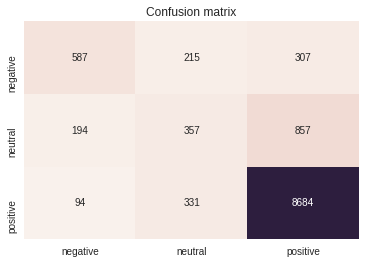

In [42]:
categories = ['negative', 'neutral', 'positive']
sns.heatmap(data=confusion_matrix(y_test, lr_log.predict(test_bow_log)),
            annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

опять, правда, слишком много нейтральных отзывов неправильно отнесено к положительным

Теперь попробуем тф-дф векторайзер в логистической регрессии, просто посмотреть, что будет

In [43]:
vec_Tf_log = TfidfVectorizer()
bow_Tf_log = vec_Tf_log.fit_transform(X_train) 
Tf_log = LogisticRegression()
Tf_log.fit(bow_Tf_log, y_train)
test_bow_Tf_log = vec_Tf_log.transform(X_test)
pred_Tf_log = Tf_log.predict(test_bow_Tf_log)
print(classification_report(y_test, pred_Tf_log))

              precision    recall  f1-score   support

          -1       0.78      0.39      0.52      1109
           0       0.52      0.08      0.13      1408
           1       0.83      0.99      0.91      9109

   micro avg       0.82      0.82      0.82     11626
   macro avg       0.71      0.49      0.52     11626
weighted avg       0.79      0.82      0.77     11626



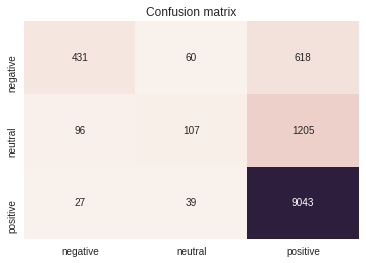

In [44]:
categories = ['negative', 'neutral', 'positive']
sns.heatmap(data=confusion_matrix(y_test, pred_Tf_log),
            annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

немного лучше бейзлайн. Теперь попробуем SGDClassifier

## SGDClassifier

In [45]:

vec_sgd = CountVectorizer()
bow_sgd = vec_sgd.fit_transform(X_train)
sgd = SGDClassifier()
sgd.fit(bow_sgd, y_train)
test_bow_sgd = vec_sgd.transform(X_test) 
print(classification_report(y_test, sgd.predict(test_bow_sgd)))


              precision    recall  f1-score   support

          -1       0.63      0.55      0.59      1109
           0       0.39      0.21      0.27      1408
           1       0.88      0.95      0.92      9109

   micro avg       0.83      0.83      0.83     11626
   macro avg       0.63      0.57      0.59     11626
weighted avg       0.80      0.83      0.81     11626



в общем-то на том же уровне, что и все остальные результаты. интересно, можно ли придумать способ лучше определять нейтральные отзывы? 
Теперь gridSearch

## GridSearch

взяла какие-то рандомные параметры, он считал их весь день и без особой пользы:

In [48]:
sgd = SGDClassifier()

grid_values = {'penalty': ['l1', 'l2'],
               'loss': ['hinge', 'log'],
               'fit_intercept':[False, True], 
               'shuffle': [False, True],
               'max_iter':[1000],
               'tol':[None, 1e-3]}
grid_sgd_acc = GridSearchCV(sgd, param_grid = grid_values)
grid_sgd_acc.fit(bow_sgd, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['hinge', 'log'], 'fit_intercept': [False, True], 'shuffle': [False, True], 'max_iter': [1000], 'tol': [None, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [52]:
print(classification_report(y_test, grid_sgd_acc.predict(test_bow_sgd)))

              precision    recall  f1-score   support

          -1       0.67      0.52      0.59      1109
           0       0.40      0.23      0.29      1408
           1       0.88      0.96      0.92      9109

   micro avg       0.83      0.83      0.83     11626
   macro avg       0.65      0.57      0.60     11626
weighted avg       0.80      0.83      0.81     11626



Видимо, параметры надо подбирать как-то более осмысленно. Тогда я залезла на Медиум и посмотрела, какие там подбирают параметры. Код ниже я стащила вот отсюда: https://medium.com/search?q=SGDClassifier 

In [1]:
sgd = SGDClassifier()
grid_values1 = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
grid_sgd_acc1 = GridSearchCV(sgd, param_grid = grid_values1)
grid_sgd_acc1.fit(bow_sgd, y_train)

NameError: ignored

после чего мой гугл коллаб протупил еще пару часов и дисконнектнулся, увы. Но эти параметры я уже пробовала до того, и особо лучших результатов они не дали. Так что я решила закончить с   GridSearch, он очень времязатратный и никаких интересных результатов ни разу не показал.

## Визуализация весов (логистическая регрессия)

In [17]:
vec = CountVectorizer()
bag_of_words = vec.fit_transform(df.text)
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df.label)
lr = LogisticRegression(random_state=88)
clf = lr.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.65      0.51      0.58      1094
           0       0.37      0.24      0.29      1409
           1       0.88      0.95      0.91      9123

   micro avg       0.82      0.82      0.82     11626
   macro avg       0.63      0.57      0.59     11626
weighted avg       0.80      0.82      0.81     11626



In [18]:
print(clf.classes_)
clf.coef_

[-1  0  1]


array([[ 0.081321  , -0.18295653,  0.1185735 , ..., -0.0023465 ,
        -0.02275359, -0.00550958],
       [-0.04262865,  0.14427497, -0.03472102, ..., -0.00255423,
         0.00209248, -0.00020915],
       [-0.01666273,  0.05605757, -0.06584016, ...,  0.00535865,
         0.01645486,  0.00775231]])

Сначала найдем 10 самых больших коэффициентов для каждого класса, для этих коэффициентов найдем индексы их токенов и запишем это всё в словарь.

In [19]:
classes = clf.classes_
dict_features={}
for i in range(len(classes)):
    max_coef = sorted(clf.coef_[i], reverse=True)[0:10]  
    dict_features[str(classes[i])] = []
    for index, val in enumerate(clf.coef_[i]):
        if val in max_coef:
            dict_features[str(classes[i])].append(index)
dict_features

{'-1': [22606,
  46304,
  77767,
  167654,
  168411,
  196224,
  268961,
  296008,
  296037,
  333327],
 '0': [11013,
  136545,
  167986,
  167988,
  204300,
  244579,
  259930,
  268815,
  291023,
  308890],
 '1': [49920,
  70514,
  134861,
  193899,
  199667,
  199675,
  200588,
  210751,
  238025,
  360655]}

In [20]:
# обратим словарь, чтобы было удобно искать слова по индексам
reverse_voc = {}
for key in vec.vocabulary_:
    index = vec.vocabulary_[key]
    reverse_voc[index] = key
len(reverse_voc)

369844

In [21]:
# Достанем самые значимые слова
tokens_dict = {}
for key in dict_features:
    tokens_dict[str(key)] = []
    for el in dict_features[key]:
        tokens_dict[str(key)].append(reverse_voc[el])
        
tokens_dict    

{'-1': ['бред',
  'выключить',
  'единственный',
  'неинтересный',
  'нелепо',
  'остальное',
  'разочарование',
  'скучно',
  'скучный',
  'ужасен'],
 '0': ['банальный',
  'любителя',
  'нейтральная',
  'нейтрально',
  'оценивать',
  'претензия',
  'проходной',
  'разок',
  'серый',
  'средний'],
 '1': ['высший',
  'добрых',
  'локи',
  'органично',
  'отличное',
  'отличный',
  'оторваться',
  'переживаешь',
  'потрясающий',
  'шикарен']}

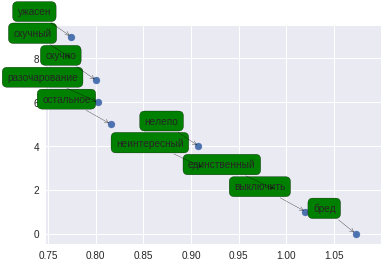

In [22]:
labels = tokens_dict['-1']
max_coef = sorted(clf.coef_[0], reverse=True)[0:10]
plt.scatter(max_coef, range(0,10))
for label, x, y in zip(labels, max_coef, range(0,10)):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=1),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

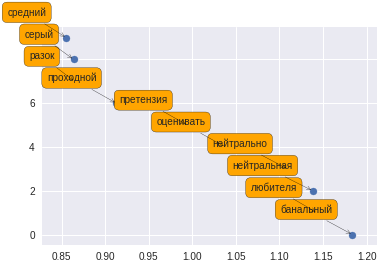

In [23]:
labels = tokens_dict['0']
max_coef = sorted(clf.coef_[1], reverse=True)[0:10]
plt.scatter(max_coef, range(0,10))
for label, x, y in zip(labels, max_coef, range(0,10)):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=1),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

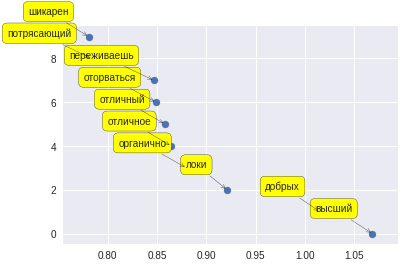

In [24]:
labels = tokens_dict['1']
max_coef = sorted(clf.coef_[2], reverse=True)[0:10]
plt.scatter(max_coef, range(0,10))
for label, x, y in zip(labels, max_coef, range(0,10)):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=1),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

### Бонус
(+2 балла к основному заданию; оценка за всё задание может быть выше 10)

Придумайте ещё 2-3 осмысленных споцоба визуализации данных или результатов. Добавьте их ниже или в текст основного задания. и сошлитесь на них здесь.